In [3]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [4]:
with open("/content/DeteksiSarkasme.json", "r") as f:
    data = [json.loads(line) for line in f]

df = pd.DataFrame(data)[['headline', 'is_sarcastic']]

In [5]:
tokenizer_tf = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer_tf.fit_on_texts(df['headline'])
sequences_tf = tokenizer_tf.texts_to_sequences(df['headline'])
padded_tf = pad_sequences(sequences_tf, maxlen=30, padding='post')

In [6]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(
    padded_tf, df['is_sarcastic'].values, test_size=0.2, random_state=42)

In [7]:
model_tf = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=64, input_length=30),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_tf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
history_tf = model_tf.fit(
    X_train_tf, y_train_tf,
    epochs=5, batch_size=64,
    validation_split=0.2
)

Epoch 1/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.6923 - loss: 0.5542 - val_accuracy: 0.8552 - val_loss: 0.3400
Epoch 2/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9111 - loss: 0.2376 - val_accuracy: 0.8353 - val_loss: 0.4118
Epoch 3/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9345 - loss: 0.1872 - val_accuracy: 0.8404 - val_loss: 0.4432
Epoch 4/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9595 - loss: 0.1253 - val_accuracy: 0.8315 - val_loss: 0.4889
Epoch 5/5
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9709 - loss: 0.0921 - val_accuracy: 0.8248 - val_loss: 0.4919


In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ====== PREDIKSI PADA TEST SET ======
y_pred_prob_tf = model_tf.predict(X_test_tf)
y_pred_tf = (y_pred_prob_tf > 0.5).astype("int32")

acc = accuracy_score(y_test_tf, y_pred_tf)
prec = precision_score(y_test_tf, y_pred_tf)
rec = recall_score(y_test_tf, y_pred_tf)
f1 = f1_score(y_test_tf, y_pred_tf)
auc = roc_auc_score(y_test_tf, y_pred_prob_tf)

print("=== METRICS EVALUASI (TensorFlow) ===")
print(f"Akurasi   : {acc:.4f}")
print(f"Presisi   : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-Score  : {f1:.4f}")
print(f"AUC Score : {auc:.4f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
=== METRICS EVALUASI (TensorFlow) ===
Akurasi   : 0.8325
Presisi   : 0.8541
Recall    : 0.7460
F1-Score  : 0.7964
AUC Score : 0.9133


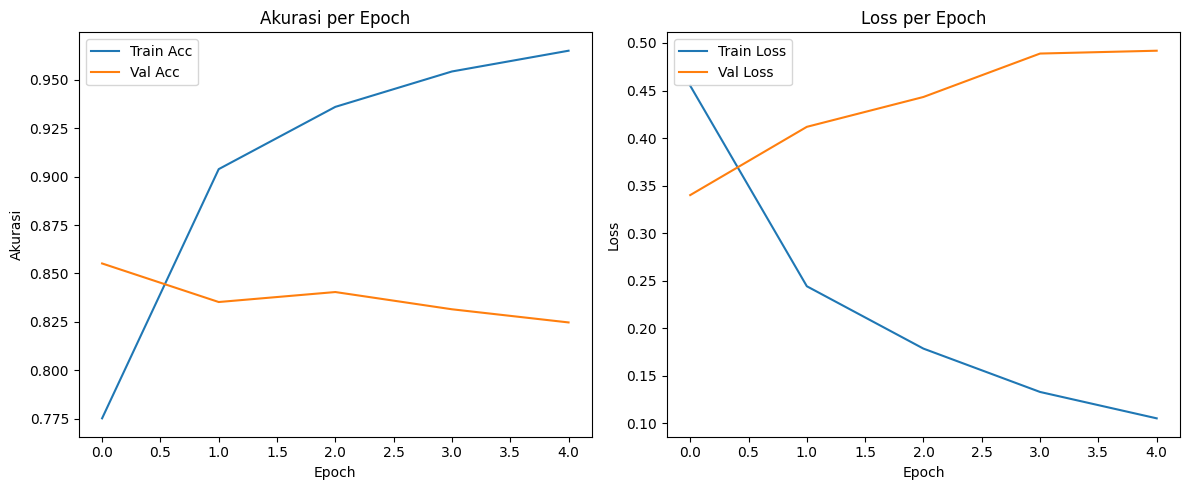

In [10]:
plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history_tf.history['accuracy'], label='Train Acc')
plt.plot(history_tf.history['val_accuracy'], label='Val Acc')
plt.title('Akurasi per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_tf.history['loss'], label='Train Loss')
plt.plot(history_tf.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

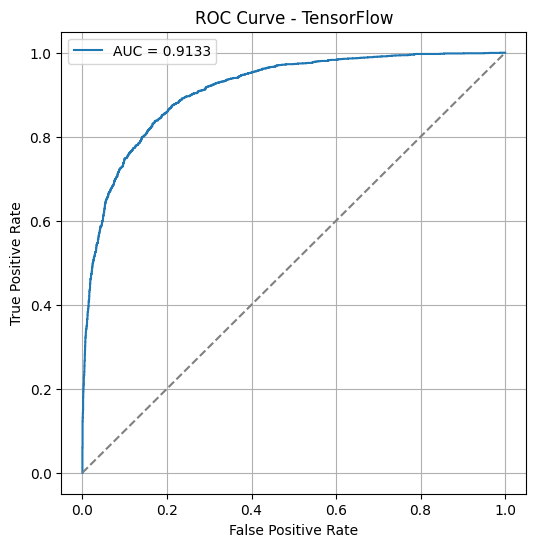

In [11]:
fpr, tpr, thresholds = roc_curve(y_test_tf, y_pred_prob_tf)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve - TensorFlow')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [12]:
tokenizer_pt = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer_pt.fit_on_texts(df['headline'])
sequences_pt = tokenizer_pt.texts_to_sequences(df['headline'])
padded_pt = pad_sequences(sequences_pt, maxlen=30, padding='post')

X_pt = padded_pt
y_pt = df['is_sarcastic'].values
X_train_pt, X_test_pt, y_train_pt, y_test_pt = train_test_split(
    X_pt, y_pt, test_size=0.2, random_state=42)

In [13]:
class SarcasmDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SarcasmDataset(X_train_pt, y_train_pt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [14]:
class LSTMSarcasm(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return self.sigmoid(out).squeeze()

model_pt = LSTMSarcasm(vocab_size=10000, embedding_dim=64, hidden_dim=64)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model_pt.parameters(), lr=0.001)

In [15]:
for epoch in range(5):
    model_pt.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model_pt(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

Epoch 1 | Loss: 0.6863
Epoch 2 | Loss: 0.6861
Epoch 3 | Loss: 0.6860
Epoch 4 | Loss: 0.6306
Epoch 5 | Loss: 0.4089


In [16]:
X_test_tensor = torch.tensor(X_test_pt, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_pt, dtype=torch.float32)

# ====== PREDIKSI MODEL ======
model_pt.eval()
with torch.no_grad():
    y_pred_prob_pt = model_pt(X_test_tensor).numpy()
    y_pred_pt = (y_pred_prob_pt > 0.5).astype("int32")

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

acc = accuracy_score(y_test_pt, y_pred_pt)
prec = precision_score(y_test_pt, y_pred_pt)
rec = recall_score(y_test_pt, y_pred_pt)
f1 = f1_score(y_test_pt, y_pred_pt)
auc = roc_auc_score(y_test_pt, y_pred_prob_pt)

print("=== METRICS EVALUASI (PyTorch) ===")
print(f"Akurasi   : {acc:.4f}")
print(f"Presisi   : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-Score  : {f1:.4f}")
print(f"AUC Score : {auc:.4f}")

=== METRICS EVALUASI (PyTorch) ===
Akurasi   : 0.8205
Presisi   : 0.7862
Recall    : 0.8120
F1-Score  : 0.7989
AUC Score : 0.9011


In [20]:
train_loss_history = []
train_acc_history = []

for epoch in range(5):
    model_pt.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model_pt(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        y_pred_label = (y_pred > 0.5).float()
        correct += (y_pred_label == y_batch).sum().item()
        total += y_batch.size(0)

    avg_loss = total_loss / len(train_loader)
    acc = correct / total

    train_loss_history.append(avg_loss)
    train_acc_history.append(acc)

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {acc:.4f}")

Epoch 1 | Loss: 0.3038 | Accuracy: 0.8734
Epoch 2 | Loss: 0.2319 | Accuracy: 0.9084
Epoch 3 | Loss: 0.1766 | Accuracy: 0.9354
Epoch 4 | Loss: 0.1301 | Accuracy: 0.9546
Epoch 5 | Loss: 0.0965 | Accuracy: 0.9694


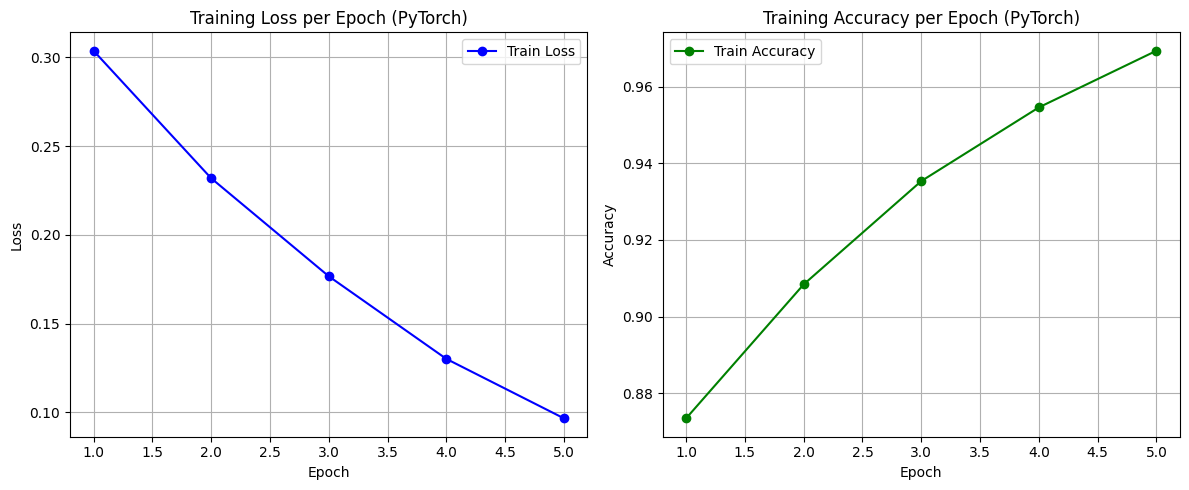

In [21]:
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b-o', label='Train Loss')
plt.title('Training Loss per Epoch (PyTorch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'g-o', label='Train Accuracy')
plt.title('Training Accuracy per Epoch (PyTorch)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

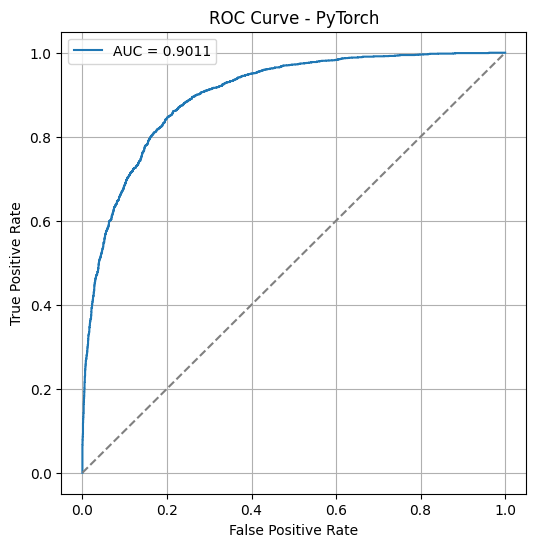

In [18]:
fpr, tpr, thresholds = roc_curve(y_test_pt, y_pred_prob_pt)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve - PyTorch')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [22]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [23]:
import keras_tuner as kt
from tensorflow.keras import layers

def build_model(hp):
    model = tf.keras.Sequential()

    # Embedding layer
    model.add(layers.Embedding(input_dim=10000, output_dim=hp.Choice('embedding_dim', [32, 64, 128]), input_length=30))

    # LSTM Layer
    model.add(layers.LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=True))
    model.add(layers.GlobalMaxPooling1D())

    # Dense Layer
    model.add(layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [24]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,              # Jumlah kombinasi yang akan diuji
    executions_per_trial=1,
    directory='my_dir',
    project_name='sarcasm_lstm_tuning'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
tuner.search(
    X_train_tf, y_train_tf,
    epochs=5,
    validation_split=0.2,
    batch_size=64
)

Trial 10 Complete [00h 00m 49s]
val_accuracy: 0.857510507106781

Best val_accuracy So Far: 0.8598502278327942
Total elapsed time: 00h 13m 19s


In [26]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("==== HYPERPARAMETER TERBAIK ====")
print(f"Embedding dim : {best_hps.get('embedding_dim')}")
print(f"LSTM units    : {best_hps.get('lstm_units')}")
print(f"Dense units   : {best_hps.get('dense_units')}")
print(f"Learning rate : {best_hps.get('learning_rate')}")

==== HYPERPARAMETER TERBAIK ====
Embedding dim : 64
LSTM units    : 128
Dense units   : 96
Learning rate : 0.007457260244324495


In [27]:
best_model = tuner.hypermodel.build(best_hps)

history_best = best_model.fit(
    X_train_tf, y_train_tf,
    epochs=10,
    validation_split=0.2,
    batch_size=64
)

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.7583 - loss: 0.4780 - val_accuracy: 0.8568 - val_loss: 0.3446
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9288 - loss: 0.1877 - val_accuracy: 0.8479 - val_loss: 0.3799
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.9617 - loss: 0.1034 - val_accuracy: 0.8446 - val_loss: 0.4568
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - accuracy: 0.9822 - loss: 0.0504 - val_accuracy: 0.8304 - val_loss: 0.6001
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.9899 - loss: 0.0289 - val_accuracy: 0.8379 - val_loss: 0.7293
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 19s 72ms/step - accuracy: 0.9953 - loss: 0.0135 - val_accuracy: 0.8255 - val_loss: 0.9019
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.9951 - loss: 0.0144 - val_accuracy: 0.8348 - val_loss: 0.6332
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.9949 - loss: 0.0151 - 